In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchinfo

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('stopwords')
nltk.download('punkt')

import torch
from torch.utils.data import DataLoader, TensorDataset
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split


import time
from torch.utils.data import  DataLoader



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
df = pd.read_csv('/content/drive/MyDrive/DL/Tweets.csv')


In [5]:
df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [6]:
df.shape

(14640, 15)

In [7]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [8]:
dup = df.duplicated()
print(dup)

0        False
1        False
2        False
3        False
4        False
         ...  
14635    False
14636    False
14637    False
14638    False
14639    False
Length: 14640, dtype: bool


In [9]:
data_types = df.dtypes
print(data_types)

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [11]:
# COlumns we dont need
# tweet_id
# airline_sentiment_confidence
# negativereason
# negativereason_confidence
# airline
# airline_sentiment_gold
# name
# negativereason_gold
# retweet_count
# tweet_coord
# tweet_created
# tweet_location
# user_timezone

# We need
# text - as this is teh tweet
# airline_sentiment	- this is the sentiment we eed to predict

ndf = df[['text','airline_sentiment']]

In [12]:
ndf.head()

text airline_sentiment
0                @VirginAmerica What @dhepburn said.           neutral
1  @VirginAmerica plus you've added commercials t...          positive
2  @VirginAmerica I didn't today... Must mean I n...           neutral
3  @VirginAmerica it's really aggressive to blast...          negative
4  @VirginAmerica and it's a really big bad thing...          negative

In [13]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 4.5 MB/s eta 0:00:00


In [14]:
import re, emoji
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def clean_text(text):
    text = emoji.demojize(text.lower())
    text = re.sub(r':\w+:|@\w+|[^a-zA-Z\s]', '', text)
    tokens = [word for word in word_tokenize(text) if word not in set(stopwords.words('english'))]
    return ' '.join(tokens)

ndf['cleanedtexto'] = ndf['text'].apply(clean_text)


In [15]:
ndf.drop(columns=['text'], inplace=True)

In [16]:
ndf.head()

airline_sentiment                                       cleanedtexto
0           neutral                                               said
1          positive      plus youve added commercials experience tacky
2           neutral       didnt today must mean need take another trip
3          negative  really aggressive blast obnoxious entertainmen...
4          negative                               really big bad thing

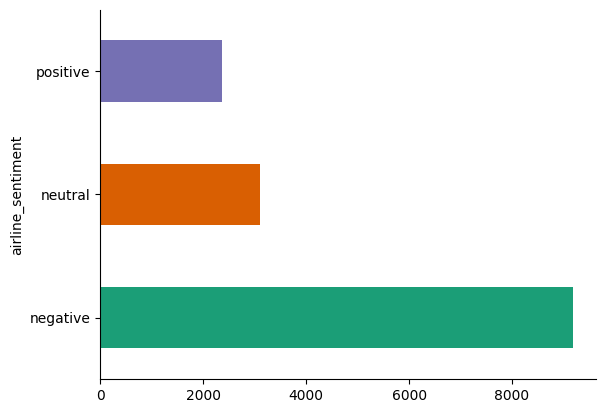

In [17]:
ndf.groupby('airline_sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

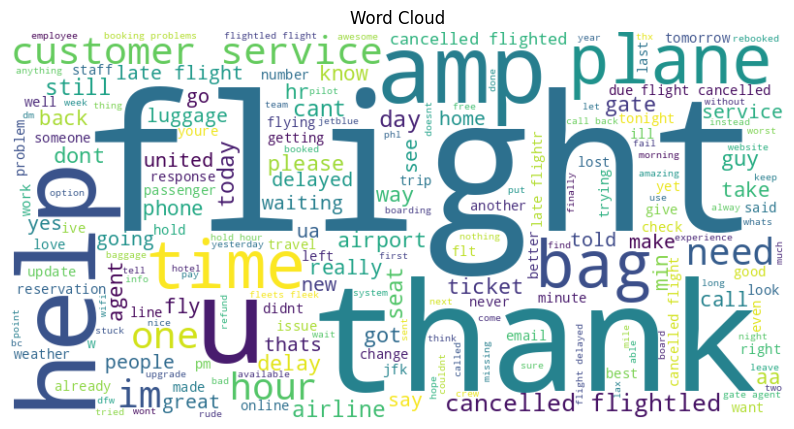

In [18]:
# Concatenate all text data
all_text = ' '.join(ndf['cleanedtexto'])

# Generate word cloud
wordcloud = WordCloud(width=800,height=400,background_color='white').generate(all_text)

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis('off')
plt.show()


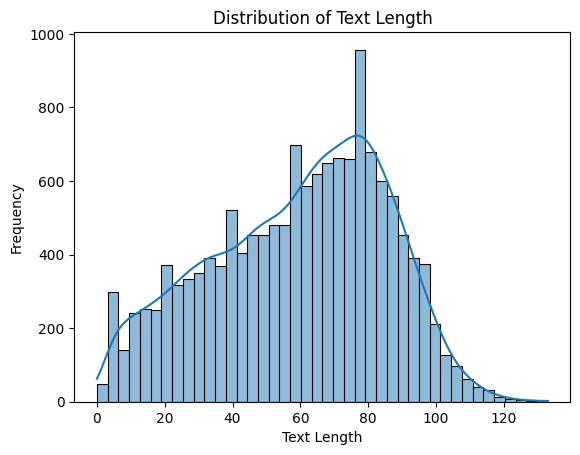

In [19]:
ndff = ndf
# Calculate text lengths
ndff['text_length'] = ndff['cleanedtexto'].apply(len)

# Plot histogram
sns.histplot(data=ndff, x='text_length', kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [20]:
ndf.drop(columns=['text_length'], inplace=True)

In [21]:
tokenizer = Tokenizer(num_words=512, lower=True, split=' ')
tokenizer.fit_on_texts(ndf['cleanedtexto'])

In [22]:
ndf.head()

airline_sentiment                                       cleanedtexto
0           neutral                                               said
1          positive      plus youve added commercials experience tacky
2           neutral       didnt today must mean need take another trip
3          negative  really aggressive blast obnoxious entertainmen...
4          negative                               really big bad thing

In [23]:

X = tokenizer.texts_to_sequences(ndf['cleanedtexto'])
# Calculate the length of each tokenized text
l_token = [len(token) for token in X]
max_tokens = np.max(l_token)
print("Maximum number of tokens:", max_tokens)

Maximum number of tokens: 18


In [24]:
# got mx token = 19 so let's pad everything to 28, to ensure everything in same size!!!
X = pad_sequences(X, padding='post', maxlen=28)

In [25]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit label encoder and transform the 'airline_sentiment' column
ndf['airline_sentiment'] = label_encoder.fit_transform(ndf['airline_sentiment'])


In [26]:
ndf.head() # 0 negative, 1 neutural and 2 is the positive

airline_sentiment                                       cleanedtexto
0                  1                                               said
1                  2      plus youve added commercials experience tacky
2                  1       didnt today must mean need take another trip
3                  0  really aggressive blast obnoxious entertainmen...
4                  0                               really big bad thing

In [27]:
y = pd.get_dummies(ndf['airline_sentiment'])

In [28]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
#Test and val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('Size of Training Set:', X_train.shape, y_train.shape)
print('Size of Validation Set:', X_val.shape, y_val.shape)
print('Size of Test Set:', X_test.shape, y_test.shape)

Size of Training Set: (8198, 28) (8198, 3)
Size of Validation Set: (2050, 28) (2050, 3)
Size of Test Set: (4392, 28) (4392, 3)


In [30]:
X_train_torch = torch.tensor(X_train, dtype=torch.long)
y_train_torch = torch.tensor(np.argmax(y_train.to_numpy(), axis=1), dtype=torch.long)
X_val_torch = torch.tensor(X_val, dtype=torch.long)
y_val_torch = torch.tensor(np.argmax(y_val.to_numpy(), axis=1), dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.long)
y_test_torch = torch.tensor(np.argmax(y_test.to_numpy(), axis=1), dtype=torch.long)

In [31]:
train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataset = TensorDataset(X_val_torch, y_val_torch)
valid_loader = DataLoader(valid_dataset, batch_size=16)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_dataset, batch_size=16)

In [32]:
print(len(train_loader))
print(len(test_loader))
print(len(valid_loader))

513
275
129


## Base model

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [34]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.2)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        dropped = self.dropout(embedded)
        lstm1_out, _ = self.lstm1(dropped)
        lstm2_out, _ = self.lstm2(lstm1_out)
        lstm3_out, _ = self.lstm3(lstm2_out)
        lstm3_out_last = lstm3_out[:, -1, :]
        output = self.fc(lstm3_out_last)
        return self.softmax(output)

In [35]:
vocab_size = 1000
model = LSTMModel(vocab_size=vocab_size, embedding_dim=128, hidden_dim=64, output_dim=3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:

print(model)

LSTMModel(
  (embedding): Embedding(1000, 128)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm1): LSTM(128, 64, batch_first=True)
  (lstm2): LSTM(64, 64, batch_first=True)
  (lstm3): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [131]:
def train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0
        train_predictions = []
        train_targets = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_accuracy = accuracy_score(train_targets, train_predictions)
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        total_valid_loss = 0
        valid_predictions = []
        valid_targets = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                valid_predictions.extend(predicted.cpu().numpy())
                valid_targets.extend(labels.cpu().numpy())

            valid_accuracy = accuracy_score(valid_targets, valid_predictions)
            avg_valid_loss = total_valid_loss / len(valid_loader)
            valid_losses.append(avg_valid_loss)
            valid_accuracies.append(valid_accuracy)

        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch {epoch + 1}/{num_epochs} took {epoch_time:.2f} seconds. "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [38]:
num_epochs = 20
device = 'cuda'
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs)

Epoch 1/20 took 19.51 seconds. Train Loss: 0.9271, Train Accuracy: 0.6210, Validation Loss: 0.9294, Validation Accuracy: 0.6210
Epoch 2/20 took 23.44 seconds. Train Loss: 0.9249, Train Accuracy: 0.6210, Validation Loss: 0.9241, Validation Accuracy: 0.6210
Epoch 3/20 took 15.56 seconds. Train Loss: 0.9248, Train Accuracy: 0.6210, Validation Loss: 0.9242, Validation Accuracy: 0.6210
Epoch 4/20 took 9.85 seconds. Train Loss: 0.9241, Train Accuracy: 0.6210, Validation Loss: 0.9249, Validation Accuracy: 0.6210
Epoch 5/20 took 8.43 seconds. Train Loss: 0.7895, Train Accuracy: 0.6736, Validation Loss: 0.7300, Validation Accuracy: 0.6995
Epoch 6/20 took 9.89 seconds. Train Loss: 0.6743, Train Accuracy: 0.7323, Validation Loss: 0.6981, Validation Accuracy: 0.7083
Epoch 7/20 took 9.92 seconds. Train Loss: 0.6252, Train Accuracy: 0.7525, Validation Loss: 0.6816, Validation Accuracy: 0.7180
Epoch 8/20 took 9.27 seconds. Train Loss: 0.5925, Train Accuracy: 0.7663, Validation Loss: 0.6800, Validatio

In [39]:

def evaluate_model(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_losses = []
    test_predictions = []
    test_targets = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            test_predictions.extend(predicted.cpu().numpy())
            test_targets.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(test_targets, test_predictions)
    test_f1 = f1_score(test_targets, test_predictions, average='weighted')
    test_precision = precision_score(test_targets, test_predictions, average='weighted')
    test_recall = recall_score(test_targets, test_predictions, average='weighted')
    test_loss = np.mean(test_losses)

    return test_accuracy, test_f1, test_precision, test_recall, test_loss,  test_targets, test_predictions


In [40]:
# Call evaluate_model to calculate test metrics
test_accuracy, test_f1, test_precision, test_recall, test_loss, test_targets, test_predictions = evaluate_model(model, test_loader, criterion)

# Print test metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Loss: {test_loss:.4f}")

Test Accuracy: 0.7516
F1 Score: 0.7467
Precision: 0.7437
Recall: 0.7516
Loss: 0.7702


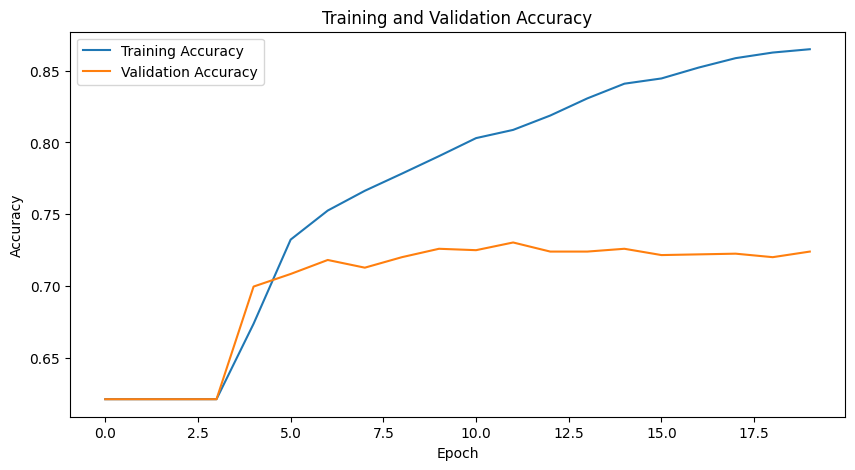

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


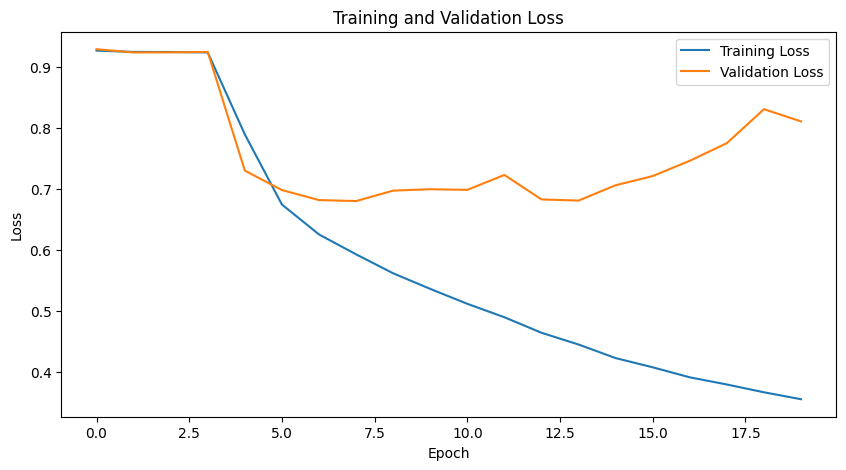

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


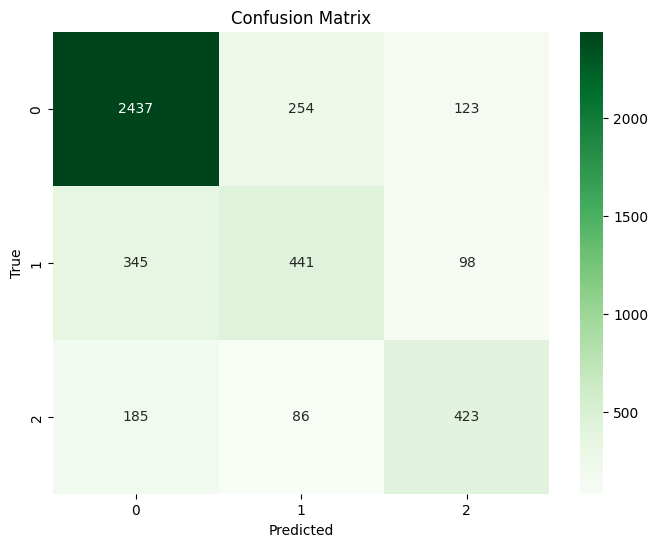

Precision: 0.7437
Recall: 0.7516
F1 Score: 0.7467


In [43]:
conf_matrix = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='g', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(test_targets, test_predictions, average='weighted')
recall = recall_score(test_targets, test_predictions, average='weighted')
f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [44]:
torch.save(model.state_dict(), 'model_base.h5')

## Base model with tuning

Whats new
- Changes to the units, embedding dim is reduced to 64 and hidden ones increased to 128, hunch is this creates more expensive training..


In [49]:
vocab_size = 1000
model_tuned = LSTMModel(vocab_size=vocab_size, embedding_dim=128, hidden_dim=128, output_dim=3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_tuned.parameters(), lr=0.01)

print(model_tuned)

LSTMModel(
  (embedding): Embedding(1000, 128)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm1): LSTM(128, 128, batch_first=True)
  (lstm2): LSTM(128, 128, batch_first=True)
  (lstm3): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [50]:
num_epochs = 20
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(model_tuned, train_loader, valid_loader, optimizer, criterion, num_epochs)

Epoch 1/20 took 29.92 seconds. Train Loss: 0.9331, Train Accuracy: 0.6189, Validation Loss: 0.9279, Validation Accuracy: 0.6210
Epoch 2/20 took 25.09 seconds. Train Loss: 0.9529, Train Accuracy: 0.6137, Validation Loss: 0.9299, Validation Accuracy: 0.6210
Epoch 3/20 took 29.46 seconds. Train Loss: 0.9245, Train Accuracy: 0.6193, Validation Loss: 0.8571, Validation Accuracy: 0.6283
Epoch 4/20 took 36.84 seconds. Train Loss: 0.7923, Train Accuracy: 0.6578, Validation Loss: 0.7659, Validation Accuracy: 0.6673
Epoch 5/20 took 47.39 seconds. Train Loss: 0.7209, Train Accuracy: 0.6904, Validation Loss: 0.7253, Validation Accuracy: 0.6932
Epoch 6/20 took 48.15 seconds. Train Loss: 0.6668, Train Accuracy: 0.7315, Validation Loss: 0.7136, Validation Accuracy: 0.7083
Epoch 7/20 took 53.02 seconds. Train Loss: 0.6497, Train Accuracy: 0.7365, Validation Loss: 0.7076, Validation Accuracy: 0.7024
Epoch 8/20 took 59.76 seconds. Train Loss: 0.6343, Train Accuracy: 0.7447, Validation Loss: 0.6866, Vali

In [51]:
# Call evaluate_model to calculate test metrics
test_accuracy, test_f1, test_precision, test_recall, test_loss, test_targets, test_predictions = evaluate_model(model_tuned, test_loader, criterion)

# Print test metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Loss: {test_loss:.4f}")

Test Accuracy: 0.7382
F1 Score: 0.7364
Precision: 0.7349
Recall: 0.7382
Loss: 0.6590


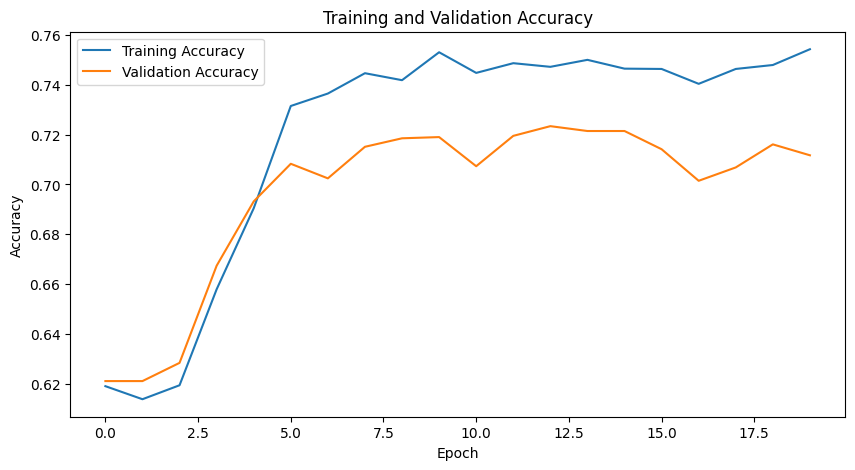

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [53]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [54]:
conf_matrix = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='g', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(test_targets, test_predictions, average='weighted')
recall = recall_score(test_targets, test_predictions, average='weighted')
f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.7349
Recall: 0.7382
F1 Score: 0.7364


In [55]:
torch.save(model_tuned.state_dict(), 'model_base_tuned.h5')

- Well as you can see desite teh changes the perfromance isn't increased and still the base models leading the pack. And this changes also made the this model inefficient. So let's take what's best and let's tweak the optimizer. 😉

### CHange 2
- Change the opptimizer to Adagrad, which is best for numerical data, as here textual data is tokenized...let's give it a try
- in the past instances the learning rate is too slow, lt's increse it

In [56]:
vocab_size = 1000
model = LSTMModel(vocab_size=vocab_size, embedding_dim=128, hidden_dim=64, output_dim=3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

In [57]:

print(model)

LSTMModel(
  (embedding): Embedding(1000, 128)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm1): LSTM(128, 64, batch_first=True)
  (lstm2): LSTM(64, 64, batch_first=True)
  (lstm3): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [58]:
num_epochs = 30
device = 'cuda'
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs)

Epoch 1/30 took 9.15 seconds. Train Loss: 0.9262, Train Accuracy: 0.6199, Validation Loss: 0.9244, Validation Accuracy: 0.6210
Epoch 2/30 took 7.79 seconds. Train Loss: 0.9237, Train Accuracy: 0.6210, Validation Loss: 0.9241, Validation Accuracy: 0.6210
Epoch 3/30 took 9.05 seconds. Train Loss: 0.9136, Train Accuracy: 0.6204, Validation Loss: 0.8809, Validation Accuracy: 0.6210
Epoch 4/30 took 8.85 seconds. Train Loss: 0.7698, Train Accuracy: 0.6525, Validation Loss: 0.7478, Validation Accuracy: 0.6717
Epoch 5/30 took 7.97 seconds. Train Loss: 0.7153, Train Accuracy: 0.6980, Validation Loss: 0.7324, Validation Accuracy: 0.6785
Epoch 6/30 took 9.01 seconds. Train Loss: 0.6818, Train Accuracy: 0.7225, Validation Loss: 0.7557, Validation Accuracy: 0.6898
Epoch 7/30 took 8.05 seconds. Train Loss: 0.6605, Train Accuracy: 0.7380, Validation Loss: 0.7418, Validation Accuracy: 0.6990
Epoch 8/30 took 8.76 seconds. Train Loss: 0.6527, Train Accuracy: 0.7346, Validation Loss: 0.7080, Validation A

In [59]:
# Call evaluate_model to calculate test metrics
test_accuracy, test_f1, test_precision, test_recall, test_loss, test_targets, test_predictions = evaluate_model(model, test_loader, criterion)

# Print test metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Loss: {test_loss:.4f}")

Test Accuracy: 0.7573
F1 Score: 0.7532
Precision: 0.7522
Recall: 0.7573
Loss: 0.6358


In [60]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


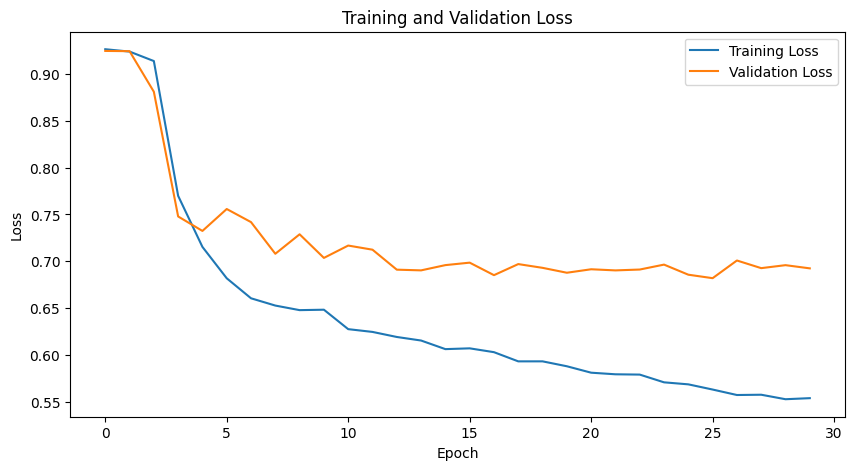

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


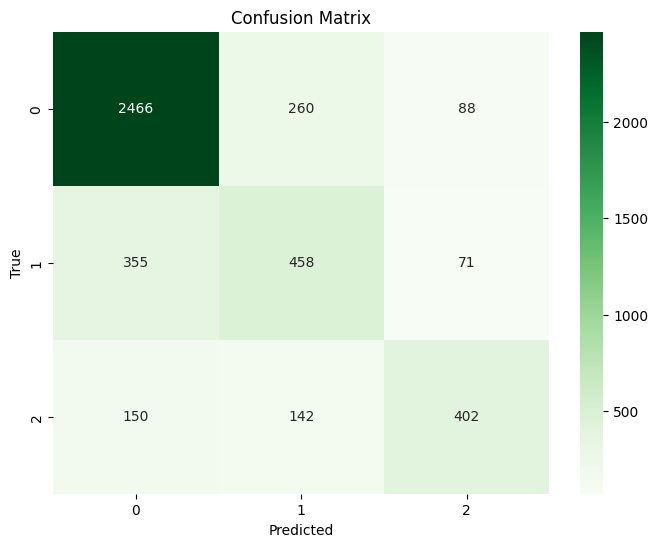

Precision: 0.7522
Recall: 0.7573
F1 Score: 0.7532


In [62]:
conf_matrix = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='g', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(test_targets, test_predictions, average='weighted')
recall = recall_score(test_targets, test_predictions, average='weighted')
f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [63]:
torch.save(model.state_dict(), 'model_base_adagrad.h5')

## Step - 2 Imporved LSTM, Iam using Bidirectional

In [64]:
class BL_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(BL_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.bilstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.bilstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.bilstm3 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        dropped = self.dropout(embedded)
        bilstm1_out, _ = self.bilstm1(dropped)
        bilstm2_out, _ = self.bilstm2(bilstm1_out)
        bilstm3_out, _ = self.bilstm3(bilstm2_out)
        bilstm3_out_last = bilstm3_out[:, -1, :]
        fc1_out = F.relu(self.fc1(bilstm3_out_last))
        output = self.fc2(fc1_out)
        return output


In [65]:
vocab_size = 1000
blmodel = BL_Model(vocab_size=vocab_size, embedding_dim=128, hidden_dim=64, output_dim=3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(blmodel.parameters(), lr=0.01)

In [66]:
print(blmodel)

BL_Model(
  (embedding): Embedding(1000, 128)
  (bilstm1): LSTM(128, 64, batch_first=True, bidirectional=True)
  (bilstm2): LSTM(128, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (bilstm3): LSTM(128, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)


In [67]:
num_epochs = 20
device = 'cuda'
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(blmodel, train_loader, valid_loader, optimizer, criterion, num_epochs)

Epoch 1/20 took 20.67 seconds. Train Loss: 0.9258, Train Accuracy: 0.6205, Validation Loss: 0.9248, Validation Accuracy: 0.6210
Epoch 2/20 took 19.28 seconds. Train Loss: 0.9238, Train Accuracy: 0.6210, Validation Loss: 0.9241, Validation Accuracy: 0.6210
Epoch 3/20 took 20.77 seconds. Train Loss: 0.9234, Train Accuracy: 0.6210, Validation Loss: 0.9253, Validation Accuracy: 0.6210
Epoch 4/20 took 19.30 seconds. Train Loss: 0.8055, Train Accuracy: 0.6544, Validation Loss: 0.7448, Validation Accuracy: 0.6795
Epoch 5/20 took 20.54 seconds. Train Loss: 0.7180, Train Accuracy: 0.6905, Validation Loss: 0.7212, Validation Accuracy: 0.6966
Epoch 6/20 took 19.31 seconds. Train Loss: 0.6801, Train Accuracy: 0.7137, Validation Loss: 0.6973, Validation Accuracy: 0.7015
Epoch 7/20 took 20.67 seconds. Train Loss: 0.6583, Train Accuracy: 0.7274, Validation Loss: 0.6978, Validation Accuracy: 0.7039
Epoch 8/20 took 19.35 seconds. Train Loss: 0.6401, Train Accuracy: 0.7368, Validation Loss: 0.6908, Vali

In [68]:
# Call evaluate_model to calculate test metrics
test_accuracy, test_f1, test_precision, test_recall, test_loss, test_targets, test_predictions = evaluate_model(blmodel, test_loader, criterion)

# Print test metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Loss: {test_loss:.4f}")

Test Accuracy: 0.7623
F1 Score: 0.7525
Precision: 0.7502
Recall: 0.7623
Loss: 0.6340


In [69]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


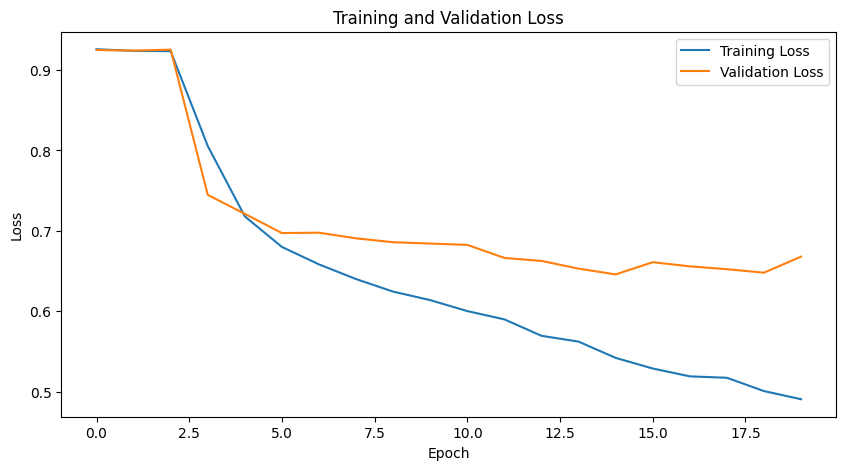

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


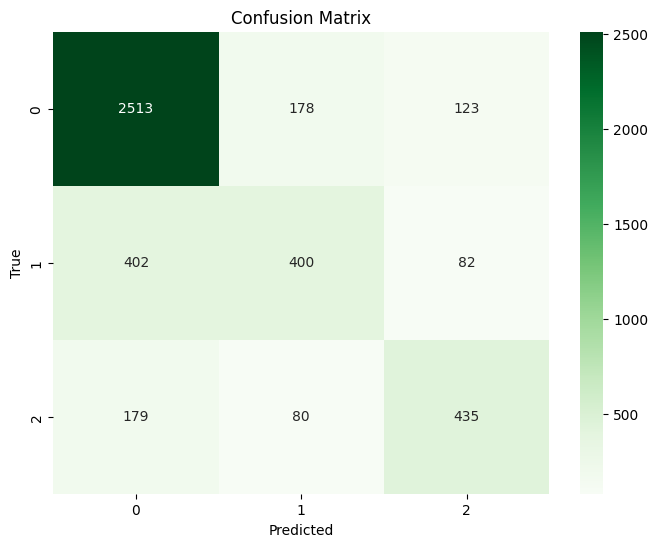

Precision: 0.7502
Recall: 0.7623
F1 Score: 0.7525


In [71]:
conf_matrix = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='g', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(test_targets, test_predictions, average='weighted')
recall = recall_score(test_targets, test_predictions, average='weighted')
f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [72]:
torch.save(blmodel.state_dict(), 'model_bl_base.h5')

## Tuning the Updated Bid-LSTM

# Change 1
- Dropout lets increase to 0.
- add one more dropout

In [116]:
class BL_Model_D(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(BL_Model_D, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.2)
        self.bilstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.bilstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.bilstm3 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        dropped = self.dropout(embedded)
        bilstm1_out, _ = self.bilstm1(dropped)
        bilstm2_out, _ = self.bilstm2(bilstm1_out)
        bilstm3_out, _ = self.bilstm3(bilstm2_out)
        dropped = self.dropout(embedded)
        bilstm3_out_last = bilstm3_out[:, -1, :]
        fc1_out = F.relu(self.fc1(bilstm3_out_last))
        output = self.fc2(fc1_out)
        return output


In [137]:
vocab_size = 1000
blmodeld = BL_Model_D(vocab_size=vocab_size, embedding_dim=128, hidden_dim=64, output_dim=3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(blmodeld.parameters(), lr=0.1)

In [138]:
print(blmodeld)

BL_Model_D(
  (embedding): Embedding(1000, 128)
  (dropout): Dropout(p=0.5, inplace=False)
  (bilstm1): LSTM(128, 64, batch_first=True, bidirectional=True)
  (bilstm2): LSTM(128, 64, batch_first=True, bidirectional=True)
  (bilstm3): LSTM(128, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)


In [139]:
num_epochs = 30
device = 'cuda'
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(blmodeld, train_loader, valid_loader, optimizer, criterion, num_epochs)

Epoch 1/30 took 21.39 seconds. Train Loss: 0.9812, Train Accuracy: 0.6183, Validation Loss: 0.9244, Validation Accuracy: 0.6210
Epoch 2/30 took 21.53 seconds. Train Loss: 0.9246, Train Accuracy: 0.6210, Validation Loss: 0.9241, Validation Accuracy: 0.6210
Epoch 3/30 took 20.12 seconds. Train Loss: 0.9239, Train Accuracy: 0.6210, Validation Loss: 0.9253, Validation Accuracy: 0.6210
Epoch 4/30 took 21.55 seconds. Train Loss: 0.9242, Train Accuracy: 0.6210, Validation Loss: 0.9238, Validation Accuracy: 0.6210
Epoch 5/30 took 21.10 seconds. Train Loss: 0.8519, Train Accuracy: 0.6227, Validation Loss: 0.8090, Validation Accuracy: 0.6541
Epoch 6/30 took 20.80 seconds. Train Loss: 0.7652, Train Accuracy: 0.6624, Validation Loss: 0.7540, Validation Accuracy: 0.6785
Epoch 7/30 took 21.54 seconds. Train Loss: 0.7378, Train Accuracy: 0.6816, Validation Loss: 0.7419, Validation Accuracy: 0.6741
Epoch 8/30 took 19.52 seconds. Train Loss: 0.7118, Train Accuracy: 0.6897, Validation Loss: 0.7306, Vali

In [140]:
# Call evaluate_model to calculate test metrics
test_accuracy, test_f1, test_precision, test_recall, test_loss, test_targets, test_predictions = evaluate_model(blmodeld, test_loader, criterion)

# Print test metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Loss: {test_loss:.4f}")

Test Accuracy: 0.7539
F1 Score: 0.7458
Precision: 0.7444
Recall: 0.7539
Loss: 0.6464


In [141]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


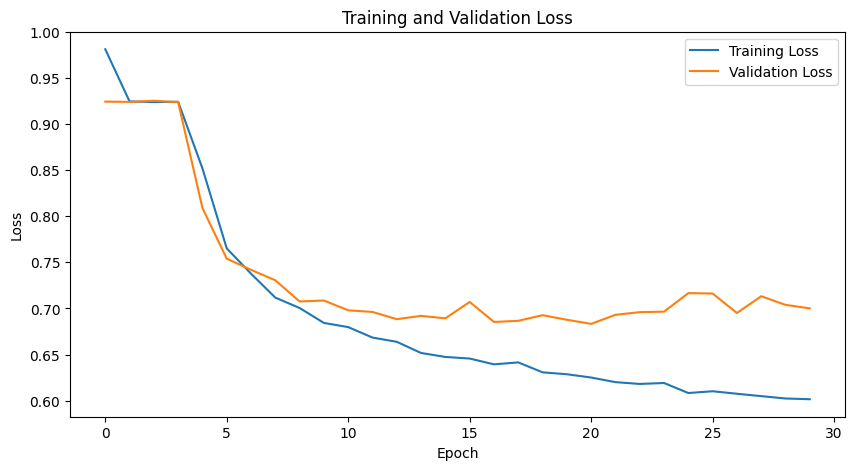

In [142]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [143]:
conf_matrix = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='g', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(test_targets, test_predictions, average='weighted')
recall = recall_score(test_targets, test_predictions, average='weighted')
f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.7444
Recall: 0.7539
F1 Score: 0.7458


In [144]:
torch.save(blmodeld.state_dict(), 'model_bl_dropc1.h5')

## Change 2
- As the base bidirectional lstm got the good accuracy, let's change the optimizer and test it

In [159]:
vocab_size = 1000
blmodel = BL_Model(vocab_size=vocab_size, embedding_dim=128, hidden_dim=64, output_dim=3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(blmodel.parameters(), lr=0.001)

In [160]:
print(blmodel)

BL_Model(
  (embedding): Embedding(1000, 128)
  (bilstm1): LSTM(128, 64, batch_first=True, bidirectional=True)
  (bilstm2): LSTM(128, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (bilstm3): LSTM(128, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)


In [161]:
num_epochs = 20
device = 'cuda'
train_losses, train_accuracies, valid_losses, valid_accuracies = train_model(blmodel, train_loader, valid_loader, optimizer, criterion, num_epochs)

Epoch 1/20 took 23.91 seconds. Train Loss: 0.9295, Train Accuracy: 0.6192, Validation Loss: 0.9247, Validation Accuracy: 0.6210
Epoch 2/20 took 19.82 seconds. Train Loss: 0.9255, Train Accuracy: 0.6210, Validation Loss: 0.9249, Validation Accuracy: 0.6210
Epoch 3/20 took 21.31 seconds. Train Loss: 0.9247, Train Accuracy: 0.6210, Validation Loss: 0.9247, Validation Accuracy: 0.6210
Epoch 4/20 took 20.01 seconds. Train Loss: 0.9241, Train Accuracy: 0.6210, Validation Loss: 0.9273, Validation Accuracy: 0.6210
Epoch 5/20 took 21.18 seconds. Train Loss: 0.9237, Train Accuracy: 0.6210, Validation Loss: 0.9250, Validation Accuracy: 0.6210
Epoch 6/20 took 19.82 seconds. Train Loss: 0.8527, Train Accuracy: 0.6389, Validation Loss: 0.7412, Validation Accuracy: 0.6668
Epoch 7/20 took 21.21 seconds. Train Loss: 0.6859, Train Accuracy: 0.7174, Validation Loss: 0.6979, Validation Accuracy: 0.7068
Epoch 8/20 took 19.79 seconds. Train Loss: 0.6326, Train Accuracy: 0.7413, Validation Loss: 0.6946, Vali

In [162]:
# Call evaluate_model to calculate test metrics
test_accuracy, test_f1, test_precision, test_recall, test_loss, test_targets, test_predictions = evaluate_model(blmodel, test_loader, criterion)

# Print test metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Loss: {test_loss:.4f}")

Test Accuracy: 0.7350
F1 Score: 0.7380
Precision: 0.7417
Recall: 0.7350
Loss: 0.7524


In [108]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


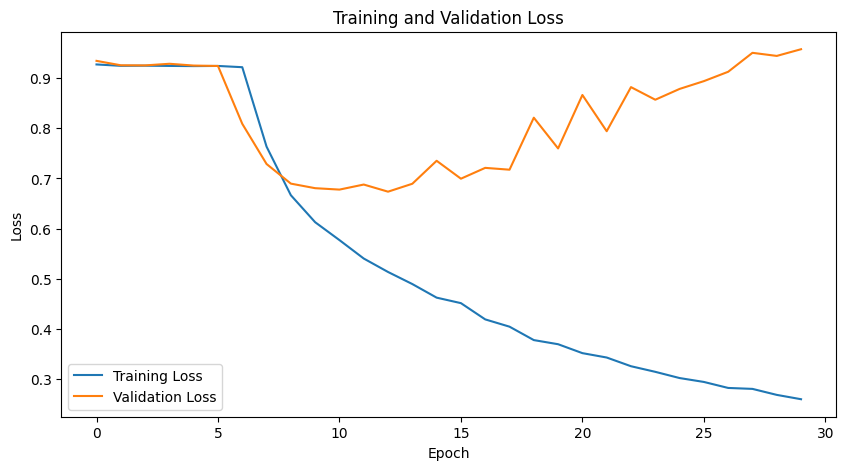

In [109]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


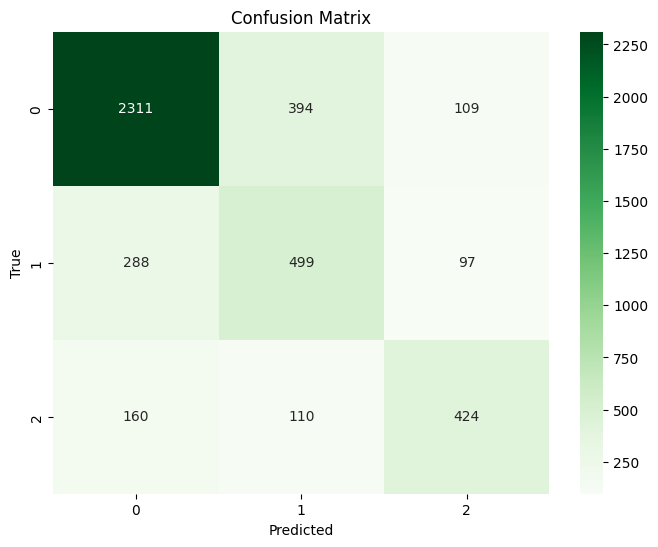

Precision: 0.7432
Recall: 0.7363
F1 Score: 0.7390


In [110]:
conf_matrix = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='g', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(test_targets, test_predictions, average='weighted')
recall = recall_score(test_targets, test_predictions, average='weighted')
f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [111]:
torch.save(blmodel.state_dict(), 'model_c2.h5')